In [391]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# MNIST - Classical MLP

Implementation in Pytorch of MLP Neural Network.

In [392]:
# Modules

# General functionality and file manipulation
import os
from datetime import datetime

# Data Processing
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

## (Quick) EDA

In [393]:
df = pd.read_csv('data/train.csv')

In [394]:
print(f'How many obs: {df.shape}')
print(df.dtypes)
print(df.describe)

How many obs: (42000, 785)
label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object
<bound method NDFrame.describe of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0      

In [395]:
a = df.iloc[0, :]
print('label' in a.index.tolist())

True


(784,)
(28, 28)


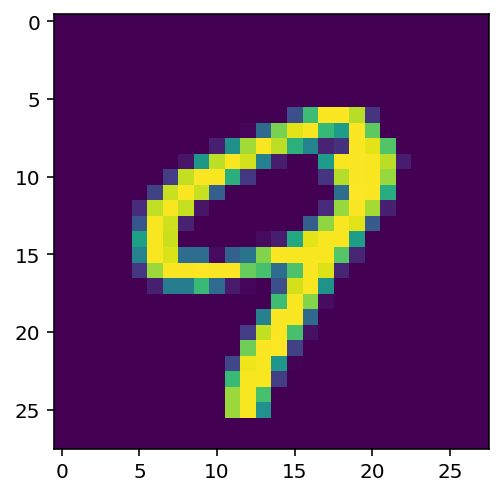

In [396]:
ex = df.iloc[100, 1:].to_numpy()
print(ex.shape)
ex.shape = (np.sqrt(784).astype('int'), -1) 
print(ex.shape)
plt.imshow(ex)

In [397]:
df.iloc[0,:].drop(labels='label')

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 0, Length: 784, dtype: int64

## Data Processing

### DataLoader and Transformations

In [398]:
class NumberImagePixel(Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        self.predict_data = not ('label' in df.columns.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        row = self.df.iloc[idx]

        if self.predict_data:
            label = -1
            features = row.to_numpy()
        else:
            label = row['label']
            features = row.drop(labels='label').to_numpy()
            
        row = {'label': label, 'features': features}
        
        if self.transform:
            row = self.transform(row)
        
        return row 
        
        

In [399]:
class Normalization(object):
    """ Normalise by mean and stdv"""
    
    def __call__(self, sample):
        label, feat = sample['label'], sample['features']
        
        feat = feat/255 #(feat - np.mean(feat))/np.std(feat)
        
        return {'label': label,
               'features': feat}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        label, features = sample['label'], sample['features']

        # If data is to be predicted.
        if label == -1:
            return {'label': label,
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

        return {'label': torch.from_numpy(np.array(label)).type(torch.LongTensor),
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

In [400]:
def make_dataloader(df, batch_size):
    data = NumberImagePixel(df=df,
                            transform=transforms.Compose([Normalization(),
                                                          ToTensor()]))
    dataloader = DataLoader(data, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    return dataloader

In [401]:
batch_size = 128
df_train = pd.read_csv('data/train.csv')
X_train, X_validation, y_train, y_validation = train_test_split(df_train[[col for col in df.columns if col != 'label']],
                                                                df_train['label'],
                                                                test_size = 0.1)

X_train['label'] = y_train
X_validation['label'] = y_validation


df_train = X_train
df_validation = X_validation
df_test = pd.read_csv('data/test.csv')
print('label' in df_train.columns.tolist())

dataloader = {}
names = ['train', 'validation', 'test']
for idx, df in enumerate([df_train, df_validation, df_test]):
    dataloader.update({names[idx]: make_dataloader(df, batch_size)})

True


In [402]:
for data in iter(dataloader['test']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1]), 'features': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
label torch.Size([128])
feat torch.Size([128, 784])


In [403]:
for data in iter(dataloader['train']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([9, 6, 7, 9, 2, 8, 9, 8, 4, 8, 9, 6, 4, 3, 2, 8, 8, 3, 0, 8, 6, 8, 5, 9,
        6, 7, 9, 7, 7, 6, 0, 1, 7, 6, 2, 8, 5, 1, 2, 8, 8, 0, 4, 0, 7, 3, 1, 3,
        4, 9, 4, 5, 0, 7, 6, 0, 9, 8, 8, 6, 9, 7, 5, 4, 7, 4, 4, 4, 2, 1, 2, 0,
        7, 0, 0, 9, 7, 2, 2, 3, 0, 9, 0, 7, 6, 2, 5, 9, 3, 1, 1, 8, 9, 6, 6, 3,
        5, 2, 9, 7, 2, 5, 9, 6, 7, 3, 8, 2, 9, 9, 3, 6, 5, 5, 0, 9, 5, 8, 4, 4,
        4, 4, 3, 7, 8, 8, 9, 2]), 'features': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
label torch.Size([128])
feat torch.Size([128, 784])


## Neural Network

### Neural Net. Architecture

In [404]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1)
        
        return x

(784,)
(28, 28)


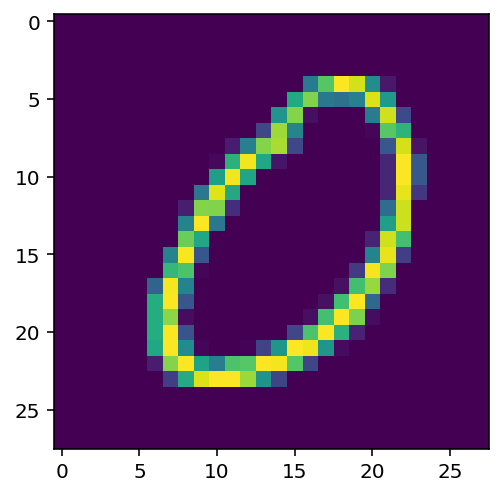

In [405]:
for data in dataloader['train']:
    data = data['features']
    ex = data[0,].numpy()
    print(ex.shape)
    ex.shape = (np.sqrt(784).astype('int'), -1) 
    print(ex.shape)
    plt.imshow(ex)
    break

In [406]:
model = MultiClassifier()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.15)


epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for data in dataloader['train']:

        images = data['features']
        labels = data['label']
        
        steps += 1
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for data in dataloader['validation']:

                    images = data['features']
                    labels = data['label']

                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(dataloader['train']))
            test_losses.append(test_loss/len(dataloader['validation']))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(dataloader['validation'])))




Epoch: 1/25..  Training Loss: 31.410..  Test Loss: 2.309..  Test Accuracy: 0.101
Epoch: 1/25..  Training Loss: 31.812..  Test Loss: 2.307..  Test Accuracy: 0.116
Epoch: 1/25..  Training Loss: 32.211..  Test Loss: 2.312..  Test Accuracy: 0.092
Epoch: 1/25..  Training Loss: 32.608..  Test Loss: 2.306..  Test Accuracy: 0.116
Epoch: 1/25..  Training Loss: 33.000..  Test Loss: 2.306..  Test Accuracy: 0.092
Epoch: 2/25..  Training Loss: 0.031..  Test Loss: 2.303..  Test Accuracy: 0.099
Epoch: 2/25..  Training Loss: 0.421..  Test Loss: 2.306..  Test Accuracy: 0.092


KeyboardInterrupt: 

### Training the model

In [411]:
def train_model(model, dataloader,
                criterion, optimizer,
                n_epoch=10, path_to_save='model.pt', 
                print_every=None):
    """
    Train our Neural Network with data and return the trained model,
    the plot diagnostics and also save the model in the path_to_save.
    
    Args:
    dataloader (dict): contains train dataloader and validation dataloader.
    path_to_save (str): path to save the model parameters in the .pt format.
    
    Returns:
    model: model trained with model.eval() = True.
    """
    # Checking if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running training on {device}")
    model = model.to(device)

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to +infinity

    train_losses = []
    valid_losses = []
    
    if print_every is None:
        print_every = int(n_epoch * 0.1) + 1
        
    for epoch in range(1, n_epoch + 1):
        
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # prep model for training
        model.train() 
        print('\n Training Loss...')
        turn = 0
        for data in dataloader['train']:

            x_train = data['features'].to(device)
            y_train = data['label'].to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_train) 
            # calculate the loss
            loss = criterion(output, y_train)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()
            
            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss}')


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        print("\n Validation Loss...")
        turn = 0
        for data in dataloader['validation']:
            x_validation = data['features'].to(device)
            y_validation = data['label'].to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_validation) # log_ps
            # calculate the loss
            loss = criterion(output, y_validation) 
            # update running validation loss 
            valid_loss += loss.item()

            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss} \n')

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(dataloader['train'])
        train_losses.append(train_loss)
        valid_loss = valid_loss/len(dataloader['validation'])
        valid_losses.append(valid_loss)

        print(f"""
            Epoch: {epoch}
            \tTraining Loss: {round(train_loss, 6)}
            \tValidation Loss: {round(valid_loss, 6)}
            """)

        # save model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased \
                ({round(valid_loss_min,6)} --> {round(valid_loss,6)}).\
                    Saving model ...')
            torch.save(model.state_dict(), path_to_save)
            valid_loss_min = valid_loss
    
    # Plotting train and validation losses.
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    
    return model

Running training on cuda

 Training Loss...
Turn 10: 22.00169825553894
Turn 20: 37.452744245529175
Turn 30: 48.219484865665436
Turn 40: 56.26621913909912
Turn 50: 62.663971185684204
Turn 60: 69.17587769031525
Turn 70: 74.44629642367363
Turn 80: 78.57934373617172
Turn 90: 82.50207817554474
Turn 100: 86.27943915128708
Turn 110: 90.31171227991581
Turn 120: 94.23597651720047
Turn 130: 98.09228706359863
Turn 140: 101.43526639044285
Turn 150: 104.54394924640656
Turn 160: 107.41656409204006
Turn 170: 110.20981241762638
Turn 180: 112.779541477561
Turn 190: 115.60975506901741
Turn 200: 118.17179028689861
Turn 210: 121.10070769488811
Turn 220: 123.61155311763287
Turn 230: 125.95513129234314
Turn 240: 129.051513671875
Turn 250: 130.9973533898592
Turn 260: 133.2383137792349
Turn 270: 135.06901329010725
Turn 280: 137.02221520990133
Turn 290: 139.07262202352285

 Validation Loss...
Turn 10: 140.59621787816286 

Turn 20: 140.59621787816286 

Turn 30: 140.59621787816286 


            Epoch: 1
       

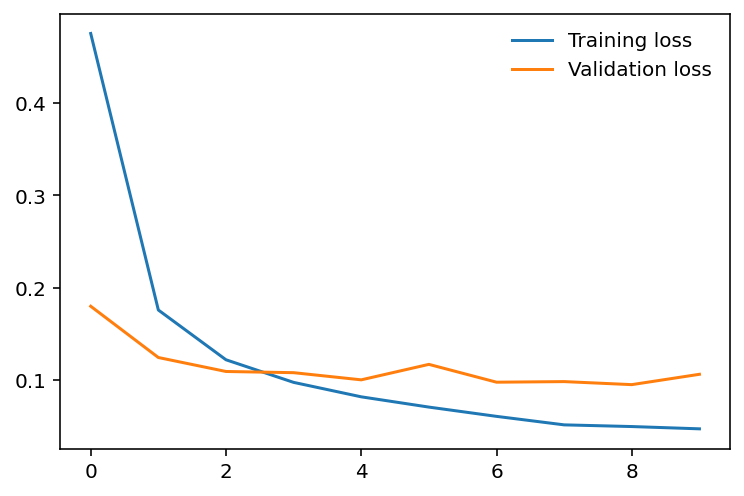

In [412]:
model = MultiClassifier()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

model = train_model(model=model, n_epoch = 10, dataloader=dataloader,criterion=criterion, optimizer=optimizer, print_every=10)

### Predict new dataset

Prob tensor([[1.0000]], device='cuda:0'), 
 Class: tensor([[3]], device='cuda:0')
(28, 28)


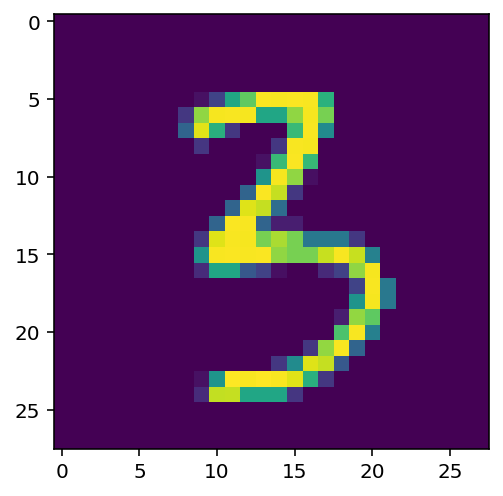

In [420]:
def predict(model, data):
    model.eval() # prepare model for evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # To speed up calculations, forget the gradients, etc.
    with torch.no_grad():
        x_cpu = data
        x = data.to(device)
        output = model(x)
        output = torch.exp(output)
        top_p, top_class = output.topk(1, dim=1)
        print(f'Prob {top_p}, \n Class: {top_class}')
        x = x_cpu.view(np.sqrt(784).astype('int'), -1)
        x = x.numpy() * 300
        print(x.shape)
        plt.imshow(x)
        plt.show()

for data in dataloader['test']:
    data = data['features'][0:1,]
    predict(model, data)
    break